In [1]:
%%capture
!pip install geopandas 
!pip install rasterio
!pip install fiona

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from sklearn.model_selection import train_test_split

import geopandas as gpd
import shutil
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize

from google.colab import drive
from shapely.geometry import Polygon, Point

import fiona
from pyproj import Proj, Transformer, transform

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
src = '/content/drive/MyDrive/MIT808 Data/Images'
dst = '/content/Images'
shutil.copytree(src, dst)

'/content/Images'

In [5]:
src = '/content/drive/MyDrive/MIT808 Data/Pre-Processed Location Data'
dst = '/content/Location Data'
shutil.copytree(src, dst)

'/content/Location Data'

In [6]:
src = '/content/drive/MyDrive/MIT808 Data/Modelling Data'
dst = '/content/Modelling Data'
shutil.copytree(src, dst)

'/content/Modelling Data'

In [7]:
# Load the first shapefile
baobab_points = gpd.read_file('/content/Location Data/s1_baobab_points.shp')

# Create an empty GeoDataFrame with the same columns as the first shapefile
combined_tree_data = gpd.GeoDataFrame(columns = baobab_points.columns)

# Loop through the remaining shapefiles and append them to the combined GeoDataFrame
for shapefile in ['/content/Location Data/s1_baobab_points.shp','/content/Location Data/s1_leadwood_points.shp', '/content/Location Data/s1_marula_points.shp', '/content/Location Data/s1_shepherd_points.shp']:
    baobab_points = gpd.read_file(shapefile)
    combined_tree_data = combined_tree_data.append(baobab_points)

# Save the combined GeoDataFrame as a new shapefile
combined_tree_data.to_file('combined_tree_data.shp')

<ipython-input-7-83302fefe716>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_tree_data = combined_tree_data.append(baobab_points)
<ipython-input-7-83302fefe716>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_tree_data = combined_tree_data.append(baobab_points)
<ipython-input-7-83302fefe716>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_tree_data = combined_tree_data.append(baobab_points)
<ipython-input-7-83302fefe716>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_tree_data = combined_tree_data.append(baobab_points)


In [8]:
image_file = '/content/Images/S1/SPOT 6/ms1707s1.tif'

site_image = rasterio.open(image_file)

In [9]:
# Check spatial resolution
resolution = site_image.res
resolution

(1.3888888888889017e-05, 1.3888888888888815e-05)

In [10]:
# Label and scale the bands for visualisation

blue, green, red, nir = site_image.read()

# scale values for visualisation purposes
def scale(band):
    return band / 1000.0

# Load the bands into numpy arrays
blue = scale(site_image.read(1))
green = scale(site_image.read(2))
red = scale(site_image.read(3))
nir = scale(site_image.read(4))

In [11]:
# Read the image data as a numpy array
image_data = site_image.read()

# Get the bounds of the image
left, bottom, right, top = site_image.bounds

In [12]:
# Create an RGB band stack to visualise the RGB composite image
image_RGB = np.dstack((red, green, blue))

In [13]:
# Reproject the point data to the same CRS as the satellite image
tree_gdf = combined_tree_data.to_crs(crs = site_image.crs)

In [14]:
# Define colors for each species
species_colours = {'Baobab': 'blue', 'Leadwood': 'orange', 'Marula': 'purple', 'Shepherd': 'red'}
species_ind = {'Baobab': 1, 'Leadwood': 2, 'Marula': 3, 'Shepherd': 4}

# Create a new column in the GeoDataFrame with the color for each species
tree_gdf['Colour'] = tree_gdf['Species'].map(species_colours)
tree_gdf['species_ind'] = tree_gdf['Species'].map(species_ind)
tree_gdf.head()

,ID,Species,x_coord,y_coord,geometry,Colour,species_ind
0,1,Baobab,30.068125,-22.330583,POINT (30.06812 -22.33058),blue,1
1,2,Baobab,30.068139,-22.330583,POINT (30.06814 -22.33058),blue,1
2,3,Baobab,30.068153,-22.330583,POINT (30.06815 -22.33058),blue,1
3,4,Baobab,30.068167,-22.330583,POINT (30.06817 -22.33058),blue,1
4,5,Baobab,30.068181,-22.330583,POINT (30.06818 -22.33058),blue,1


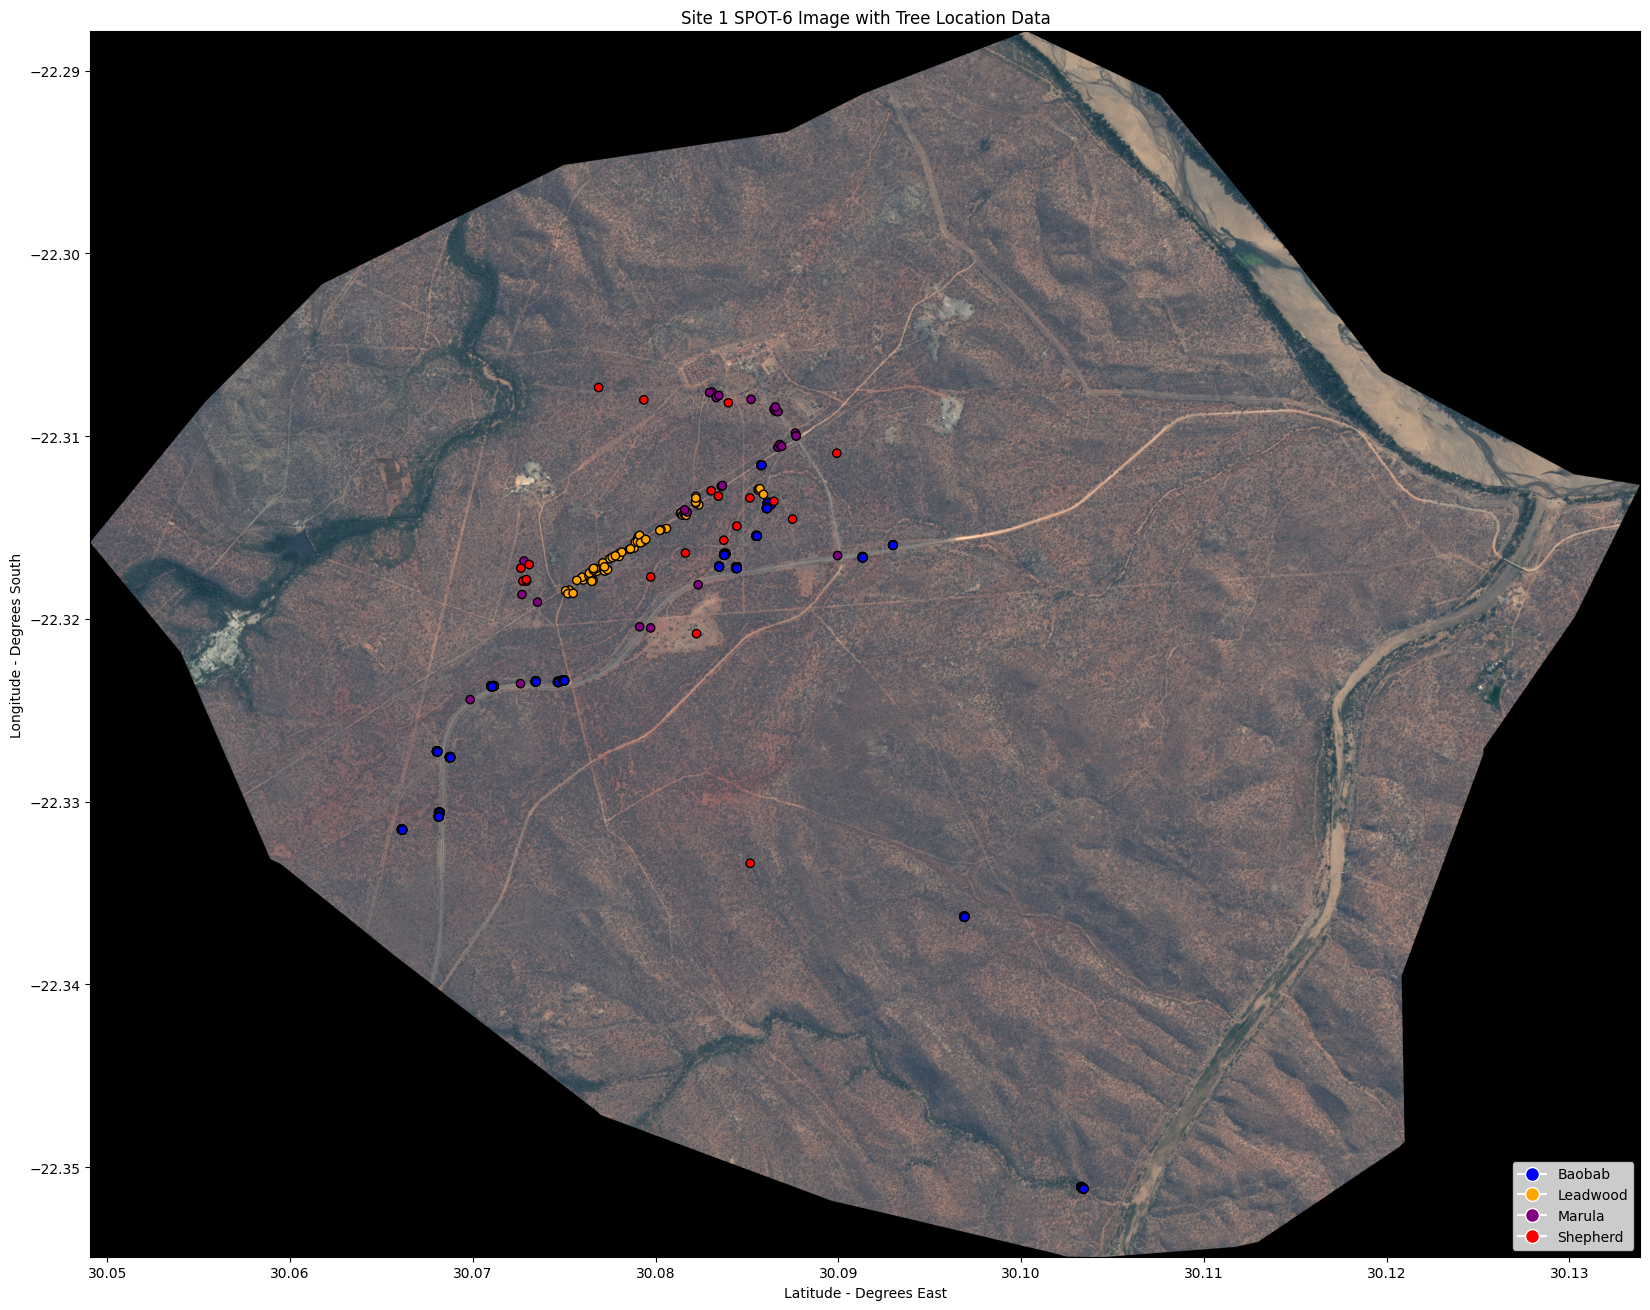

In [15]:
# Plot the RGB composite image to see the as-is colour
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image_RGB, extent=[left, right, bottom, top])

# Plot the reprojected point data onto the satellite image
ax.scatter(tree_gdf.geometry.x, tree_gdf.geometry.y, edgecolor='black', c = tree_gdf['Colour'])

# Add a legend to the plot
legend_elements = [mlines.Line2D([0], [0], marker = 'o', color = 'w', label = s, markerfacecolor = c, markersize = 10) for s, c in species_colours.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.xlabel('Latitude - Degrees East')
plt.ylabel('Longitude - Degrees South')
plt.title('Site 1 SPOT-6 Image with Tree Location Data')
plt.show()

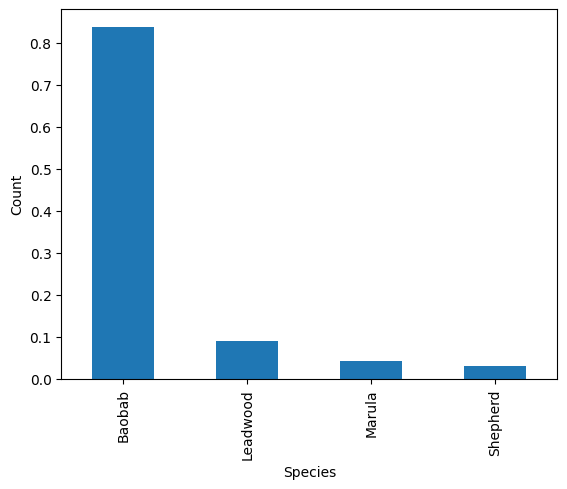

In [16]:
# Create a pandas Series object with the value counts of the "Species" column in tree_gdf
species_count = tree_gdf['Species'].value_counts(normalize = True)

# Create a bar chart of the species counts
species_count.plot.bar()

# Set the x-label and y-label
plt.xlabel('Species')
plt.ylabel('Count')

# Show the plot
plt.show()

In [17]:
species_count_num = tree_gdf['Species'].value_counts()
species_count_num

Baobab      560
Leadwood     60
Marula       28
Shepherd     20
Name: Species, dtype: int64

In [18]:
# Define the majority class
majority_class = "Baobab"
minority_class = "Leadwood"

# Set a random seed for reproducibility
np.random.seed(42)

# Identify the number of samples of the minority class/not majority class
#minority_class_size = len(tree_gdf[tree_gdf['Species'] != majority_class])

minority_class_size = len(tree_gdf[tree_gdf['Species'] == minority_class])
majority_class_size = len(tree_gdf[tree_gdf['Species'] == majority_class])
undersample_size = minority_class_size
print('Undersampling size:', undersample_size)

Undersampling size: 60


In [19]:
# Step 3: Create a boolean mask to identify the samples belonging to the majority and minority classes
is_not_majority = tree_gdf['Species'] != majority_class
is_majority = tree_gdf['Species'] == majority_class

In [20]:
# Randomly select the required number of samples from the majority class
majority_indices = np.random.choice(tree_gdf[is_majority].index, size = undersample_size, replace = False)
majority_indices

array([453, 341, 177,  86, 332, 140, 272, 296, 101, 518, 410, 553, 155,
        55, 275, 172, 517, 165, 144, 204, 396,  10, 467, 506, 244, 346,
         6, 301,  72, 442, 527,  83,  81, 148, 384, 234, 479, 371,  78,
       531, 460,  30, 145, 132, 368, 487, 281,  73,  39,  90,  70,   2,
       556, 227, 185, 163, 555,  79, 376, 524])

In [21]:
# Concatenate the samples from the minority class with the randomly selected samples from the majority class to create the final undersampled dataset
majority_samples = tree_gdf[is_majority].loc[majority_indices]
minority_samples = tree_gdf[is_not_majority]
undersampled_df = pd.concat([majority_samples, minority_samples], ignore_index = True)
undersampled_df.shape

(168, 7)

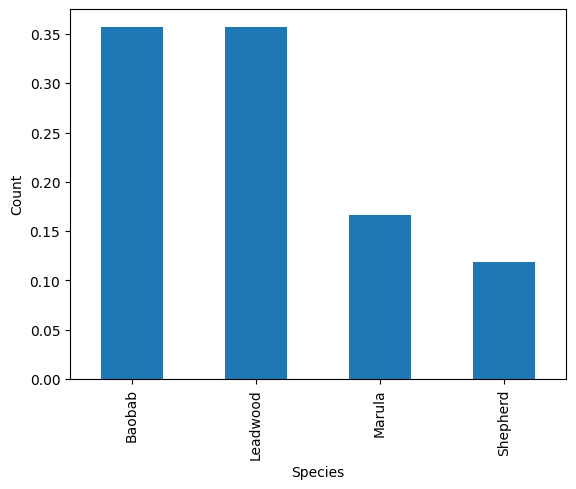

In [22]:
# Create a pandas Series object with the value counts of the "Species" column in tree_gdf
species_count = undersampled_df['Species'].value_counts(normalize = True)

# Create a bar chart of the species counts
species_count.plot.bar()

# Set the x-label and y-label
plt.xlabel('Species')
plt.ylabel('Count')

# Show the plot
plt.show()

In [23]:
species_count_num = undersampled_df['Species'].value_counts(normalize = False)
species_count_num

Baobab      60
Leadwood    60
Marula      28
Shepherd    20
Name: Species, dtype: int64

In [24]:
undersampled_df.head()

,ID,Species,x_coord,y_coord,geometry,Colour,species_ind
0,454,Baobab,30.074986,-22.323389,POINT (30.07499 -22.32339),blue,1
1,342,Baobab,30.071167,-22.323653,POINT (30.07117 -22.32365),blue,1
2,178,Baobab,30.086069,-22.313958,POINT (30.08607 -22.31396),blue,1
3,87,Baobab,30.068778,-22.327542,POINT (30.06878 -22.32754),blue,1
4,333,Baobab,30.079083,-22.315569,POINT (30.07908 -22.31557),blue,1


In [25]:
gdf = undersampled_df.copy()

if isinstance(gdf, gpd.GeoDataFrame):
    print("gdf is a GeoDataFrame")

gdf is a GeoDataFrame


In [26]:
gdf.head()

,ID,Species,x_coord,y_coord,geometry,Colour,species_ind
0,454,Baobab,30.074986,-22.323389,POINT (30.07499 -22.32339),blue,1
1,342,Baobab,30.071167,-22.323653,POINT (30.07117 -22.32365),blue,1
2,178,Baobab,30.086069,-22.313958,POINT (30.08607 -22.31396),blue,1
3,87,Baobab,30.068778,-22.327542,POINT (30.06878 -22.32754),blue,1
4,333,Baobab,30.079083,-22.315569,POINT (30.07908 -22.31557),blue,1


In [27]:
with rasterio.open(image_file) as src:
    image_meta = src.meta.copy()

image_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 6107,
 'height': 4828,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(1.3888888888889017e-05, 0.0, 30.04906944444445,
        0.0, -1.3888888888888815e-05, -22.28784722222222)}

In [28]:
# Reproject the point data to the same CRS as the satellite image
gdf = undersampled_df.to_crs(crs = site_image.crs)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
if gdf.crs == site_image.crs:
    print("The CRS of the GeoDataFrame and image match.")
else:
    print("The CRS of the GeoDataFrame and image do not match.")

The CRS of the GeoDataFrame and image match.


In [30]:
# Define the projected CRS for buffering
target_crs = 'EPSG:4326'  # Replace 'XXXX' with the desired CRS code

# Reproject the geometries to the projected CRS
projected_gdf = gdf.to_crs(target_crs)
projected_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
projected_gdf.head()

,ID,Species,x_coord,y_coord,geometry,Colour,species_ind
0,454,Baobab,30.074986,-22.323389,POINT (30.07499 -22.32339),blue,1
1,342,Baobab,30.071167,-22.323653,POINT (30.07117 -22.32365),blue,1
2,178,Baobab,30.086069,-22.313958,POINT (30.08607 -22.31396),blue,1
3,87,Baobab,30.068778,-22.327542,POINT (30.06878 -22.32754),blue,1
4,333,Baobab,30.079083,-22.315569,POINT (30.07908 -22.31557),blue,1


In [32]:
from shapely.ops import transform
from functools import partial
import pyproj

buffer_distance = 0.0002

# Define the buffer function using the projected CRS
projected_buffer = partial(pyproj.transform, pyproj.Proj(gdf.crs), pyproj.Proj(target_crs))
buffered_geometry = projected_gdf.geometry.buffer(buffer_distance).to_crs(gdf.crs)

<ipython-input-32-cae6a33fb9af>:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometry = projected_gdf.geometry.buffer(buffer_distance).to_crs(gdf.crs)


In [33]:
# Create a new GeoDataFrame with the buffered polygons
polygon_gdf = gpd.GeoDataFrame(gdf, geometry = buffered_geometry)
polygon_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
polygon_gdf.head()

,ID,Species,x_coord,y_coord,geometry,Colour,species_ind
0,454,Baobab,30.074986,-22.323389,"POLYGON ((30.07519 -22.32339, 30.07519 -22.323...",blue,1
1,342,Baobab,30.071167,-22.323653,"POLYGON ((30.07137 -22.32365, 30.07137 -22.323...",blue,1
2,178,Baobab,30.086069,-22.313958,"POLYGON ((30.08627 -22.31396, 30.08627 -22.313...",blue,1
3,87,Baobab,30.068778,-22.327542,"POLYGON ((30.06898 -22.32754, 30.06898 -22.327...",blue,1
4,333,Baobab,30.079083,-22.315569,"POLYGON ((30.07928 -22.31557, 30.07928 -22.315...",blue,1


In [35]:
if gdf.crs == polygon_gdf.crs:
    print("The CRS of the GeoDataFrames match.")
else:
    print("The CRS of the GeoDataFrames do not match.")

The CRS of the GeoDataFrames match.


In [36]:
polygon_gdf.head()

,ID,Species,x_coord,y_coord,geometry,Colour,species_ind
0,454,Baobab,30.074986,-22.323389,"POLYGON ((30.07519 -22.32339, 30.07519 -22.323...",blue,1
1,342,Baobab,30.071167,-22.323653,"POLYGON ((30.07137 -22.32365, 30.07137 -22.323...",blue,1
2,178,Baobab,30.086069,-22.313958,"POLYGON ((30.08627 -22.31396, 30.08627 -22.313...",blue,1
3,87,Baobab,30.068778,-22.327542,"POLYGON ((30.06898 -22.32754, 30.06898 -22.327...",blue,1
4,333,Baobab,30.079083,-22.315569,"POLYGON ((30.07928 -22.31557, 30.07928 -22.315...",blue,1


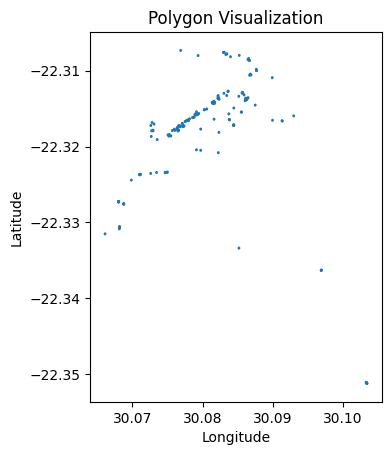

In [37]:
# Plot the polygons
polygon_gdf.plot()

# Add title and labels
plt.title("Polygon Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [38]:
species_count = polygon_gdf['Species'].value_counts(normalize = False)
species_count

Baobab      60
Leadwood    60
Marula      28
Shepherd    20
Name: Species, dtype: int64

In [39]:
# Save the GeoDataFrame to a shapefile
polygon_gdf.to_file('polygon_shapefile.shp')
polygon_path = '/content/polygon_shapefile.shp'

<ipython-input-39-a2df91e742c5>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygon_gdf.to_file('polygon_shapefile.shp')


In [40]:
polygon_test = gpd.read_file('/content/polygon_shapefile.shp')
polygon_test.head()

,ID,Species,x_coord,y_coord,Colour,species_in,geometry
0,454,Baobab,30.074986,-22.323389,blue,1,"POLYGON ((30.07519 -22.32339, 30.07519 -22.323..."
1,342,Baobab,30.071167,-22.323653,blue,1,"POLYGON ((30.07137 -22.32365, 30.07137 -22.323..."
2,178,Baobab,30.086069,-22.313958,blue,1,"POLYGON ((30.08627 -22.31396, 30.08627 -22.313..."
3,87,Baobab,30.068778,-22.327542,blue,1,"POLYGON ((30.06898 -22.32754, 30.06898 -22.327..."
4,333,Baobab,30.079083,-22.315569,blue,1,"POLYGON ((30.07928 -22.31557, 30.07928 -22.315..."


In [41]:
import fiona
from shapely.geometry import shape
from pyproj import Proj, Transformer
import geopandas as gpd

def load_and_transform_shapefile(uri, property_name, target_crs=None):
    # Open the shapefile
    with fiona.open(uri, "r") as shapefile:
        # Extract labels and polygons
        labels = []
        polygons = []
        
        for feature in shapefile:
          label = feature['properties'].get(property_name)
          labels.append(label)

            # Convert the feature's geometry to shapely object
          geom = shape(feature['geometry'])
          polygons.append(geom)

        # transform coordinates if necessary
        if target_crs is not None:
            # get the CRS of the polygons
            src_crs = shapefile.crs['init']

            # make a proj object for the source CRS
            src_proj = Proj(init=src_crs)

            # make a proj object for the target CRS
            target_proj = Proj(init=target_crs)

            # make transformer object for fast transformations
            transformer = Transformer.from_proj(src_proj, target_proj)

            # transform coordinates of each polygon
            transformed_polygons = []
            for poly in polygons:
                # extract the coordinates of the polygon
                coords = list(poly.exterior.coords)

                # transform coordinates
                transformed_coords = []
                for coord in coords:
                    x, y = transformer.transform(coord[0], coord[1])
                    transformed_coords.append((x, y))

                # create a new transformed polygon
                transformed_polygon = gpd.GeoSeries([shape({"type": "Polygon", "coordinates": [transformed_coords]})])
                transformed_polygons.append(transformed_polygon[0])

            polygons = transformed_polygons

    return polygons, labels

In [42]:
polygons, labels = load_and_transform_shapefile(polygon_path,'species_in',image_meta['crs'])

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [43]:
def calculate_polygon_radius(polygon):
    # Calculate the centroid of the polygon
    centroid = polygon.centroid

    # Calculate the distance from the centroid to the boundary of the polygon
    radius = centroid.distance(polygon.boundary)

    return radius

 # Calculate the radius for each polygon
polygon_radii = [calculate_polygon_radius(p) for p in polygons]

# Calculate the average radius
patch_radius = np.mean(polygon_radii) * 15000   
patch_radius

2.996386368392212

In [44]:
# Split up polygons into train, val, test here
train_inds, test_inds = train_test_split(range(len(polygons)),test_size = 0.3,random_state = 42, stratify = labels)

# Split the train set into train and validation sets
train_inds, val_inds = train_test_split(train_inds, test_size = 0.2, random_state = 42, stratify = [labels[i] for i in train_inds])

In [45]:
# Extract the polygons and labels for each split
train_polygons = [polygons[i] for i in train_inds]
train_labels = [labels[i] for i in train_inds]

val_polygons = [polygons[i] for i in val_inds]
val_labels = [labels[i] for i in val_inds]

test_polygons = [polygons[i] for i in test_inds]
test_labels = [labels[i] for i in test_inds]

In [46]:
print(len(val_polygons))

24


In [47]:
train_path = '/content/drive/MyDrive/MIT808 Data/Modelling Data/train_labels.tif'
val_path = '/content/drive/MyDrive/MIT808 Data/Modelling Data/val_labels.tif'
test_path = '/content/drive/MyDrive/MIT808 Data/Modelling Data/test_labels.tif'

In [48]:
from rasterio import features

def rasterize_shapefile(polygons, labels, metadata, uri):

  # copy the metadata and set the data type to uint8, no-data-value to 255
  labels_meta = metadata.copy()
  labels_meta['dtype'] = 'uint16'
  labels_meta['nodata'] = 255
  labels_meta['count'] = 4

  # open the raster file to be written
  with rasterio.open(uri, 'w', compress='lzw', **labels_meta,) as out:
    # get all polygons and labels
    shapes = ((geom,value) for geom, value in zip(polygons, labels))
    print(shapes)

    # create the raster
    raster = features.rasterize(shapes = shapes, fill = labels_meta['nodata'], out_shape = out.shape, transform=out.transform)

    # write the raster out to file
    out.write_band(1, raster)

  return raster

In [49]:
train_labels_raster = rasterize_shapefile(train_polygons, train_labels, image_meta, train_path)

<generator object rasterize_shapefile.<locals>.<genexpr> at 0x7fab8f56a8f0>


In [50]:
val_labels_raster = rasterize_shapefile(val_polygons, val_labels, image_meta, val_path)

<generator object rasterize_shapefile.<locals>.<genexpr> at 0x7fab8f56a880>


In [51]:
# Read the raster image
with rasterio.open(val_path) as src:
    # Read the raster values
    val_labels_array = src.read(1)

# Inspect the properties of the raster
print("Raster shape:", val_labels_array.shape)
print("Raster data type:", val_labels_array.dtype)
print("No data value:", src.nodata)
print("Raster transform:", src.transform)

# Inspect a sample value from the raster
sample_value = val_labels_array[0, 0]  # Assuming 2D raster, adjust indices accordingly
print("Sample value:", sample_value)

Raster shape: (4828, 6107)
Raster data type: uint16
No data value: 255.0
Raster transform: | 0.00, 0.00, 30.05|
| 0.00,-0.00,-22.29|
| 0.00, 0.00, 1.00|
Sample value: 255


In [52]:
test_labels_raster = rasterize_shapefile(test_polygons, test_labels, image_meta, test_path)

<generator object rasterize_shapefile.<locals>.<genexpr> at 0x7fab8f56ace0>


In [53]:
import tqdm

def extract_patches(image_uri, patch_radius, labels_uri):
    """Extract patches from an image based on labeled pixels.
    At each labeled pixel, we extract a square patch around it. We discard the patch if it contains "no data" pixels.
    Arguments:
      image_uri: URI for image
      patch_radius: radius of patch (e.g., radius of 7 = 15x15 patch)
      labels_uri: URI for the labels raster
    Returns:
      image patches, patch labels
    """

    # "no data value" for labels
    label_ndv = 255

    # open the hyperspectral image
    image = rasterio.open(image_uri)
    image_ndv = image.meta['nodata']
    image_width = image.meta['width']
    image_height = image.meta['height']
    image_count = image.meta['count']

    with rasterio.open(labels_uri, 'r') as f:
        labels_raster = f.read(1)

    # create lists for the patches and labels
    image_patches = []
    patch_labels = []

    # get all labeled locations in the labels raster
    rows, cols = np.where(labels_raster != label_ndv)

    # extract the patch for each location
    # tqdm makes the cool progress bar that you see
    with tqdm.tqdm(total=len(rows)) as pbar:
        for row, col in zip(rows, cols):
            # increment the progress bar
            pbar.update(1)

            # check patch bounds against image bounds
            if (
                row - patch_radius < 0
                or col - patch_radius < 0
                or row + patch_radius >= image_height
                or col + patch_radius >= image_width
            ):
                continue

            # get patch from image
            image_patch = image.read(
                window=(
                    (row - patch_radius, row + patch_radius + 1),
                    (col - patch_radius, col + patch_radius + 1),
                )
            )

            # check for nodata in patch
            if np.any(image_patch < 0):
                continue

            # append the patch and label to the lists
            image_patches.append(image_patch)
            patch_labels.append(labels_raster[row, col])

    # close the raster file
    image.close()

    # stack the patches into a numpy array
    image_patches = np.stack(image_patches, axis=0)

    # re-order the dimensions so that we have (index, height, width, channels)
    image_patches = np.transpose(image_patches, axes=[0, 2, 3, 1])

    # stack the labels into a numpy array
    patch_labels = np.stack(patch_labels, axis=0)

    return image_patches, patch_labels

In [54]:
# Extract patches using the specified radii
val_image_patches, val_patch_labels = extract_patches(image_file, patch_radius, val_path)

100%|██████████| 15202/15202 [00:01<00:00, 8779.39it/s]


In [55]:
num_patches = val_image_patches.shape[0]
num_patches

15202

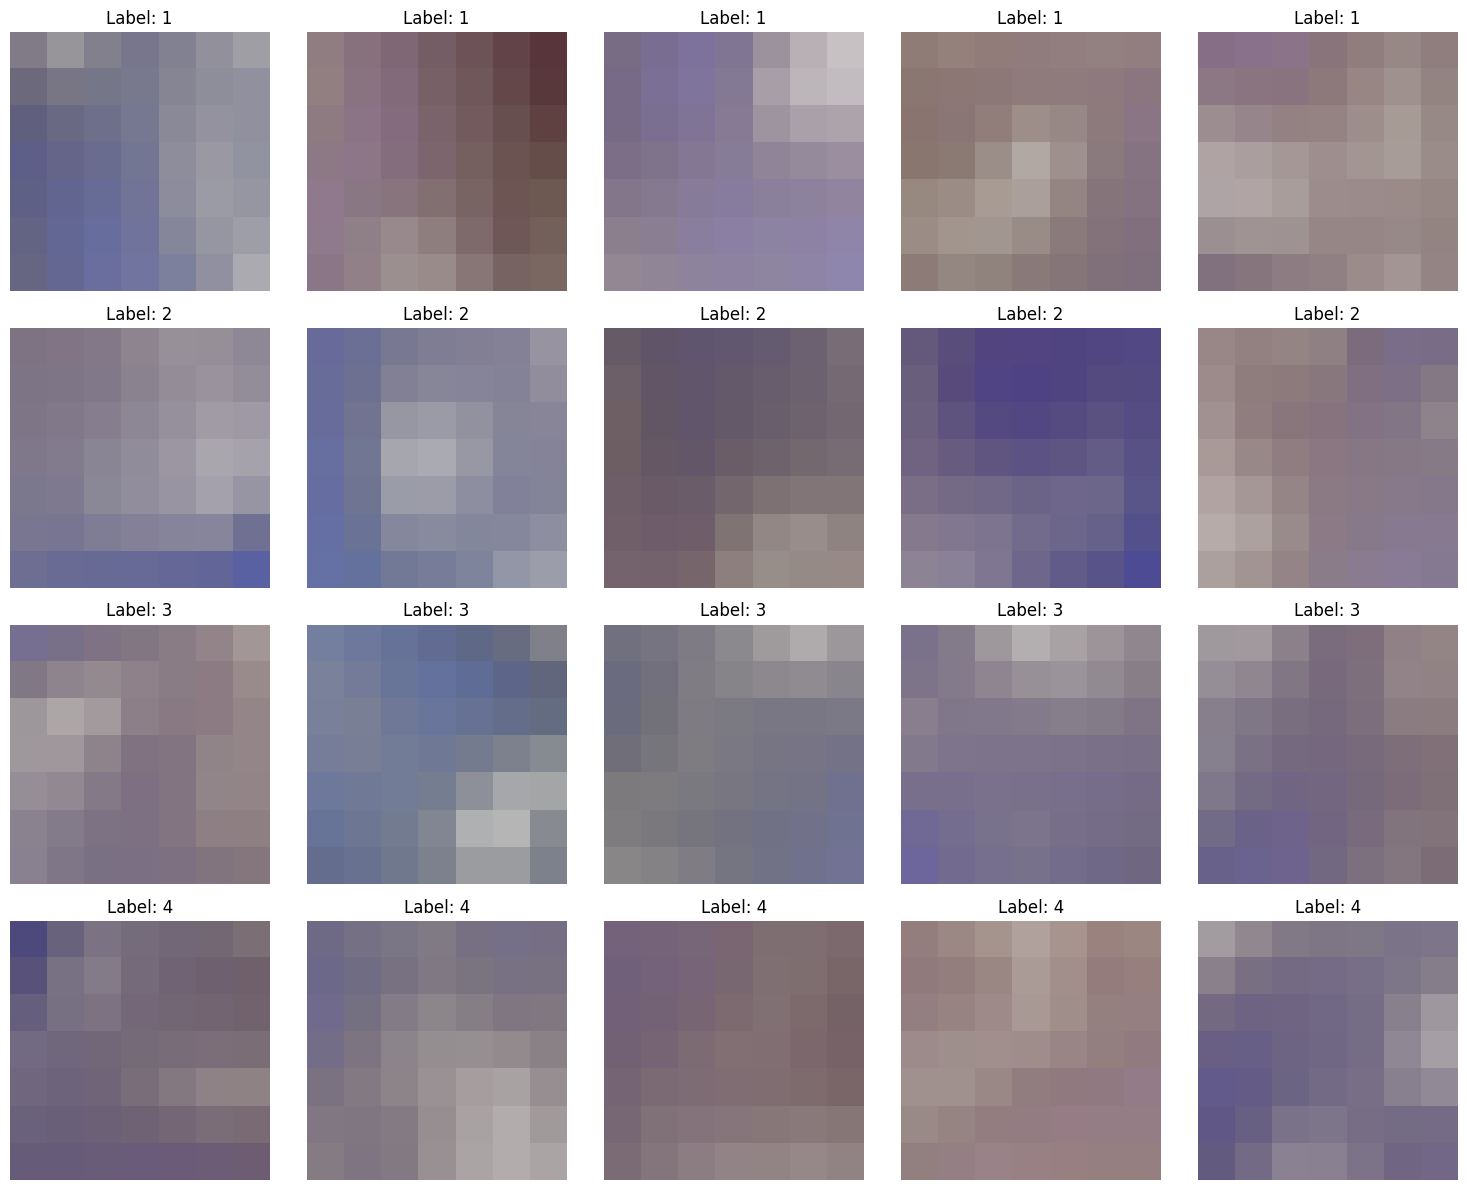

In [56]:
import random

num_display = 5
labels_to_display = set(val_patch_labels)  # Get unique labels

fig, axes = plt.subplots(len(labels_to_display), num_display, figsize=(15, 3*len(labels_to_display)))

for i, label in enumerate(labels_to_display):
    patches = val_image_patches[val_patch_labels == label]
    random_indices = random.sample(range(len(patches)), num_display)
    
    for j, idx in enumerate(random_indices):
        patch = patches[idx]
        
        # Normalize the patch
        normalized_patch = (patch - patch.min()) / (patch.max() - patch.min())
        
        axes[i, j].imshow(normalized_patch)
        axes[i, j].set_title('Label: {}'.format(label))
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

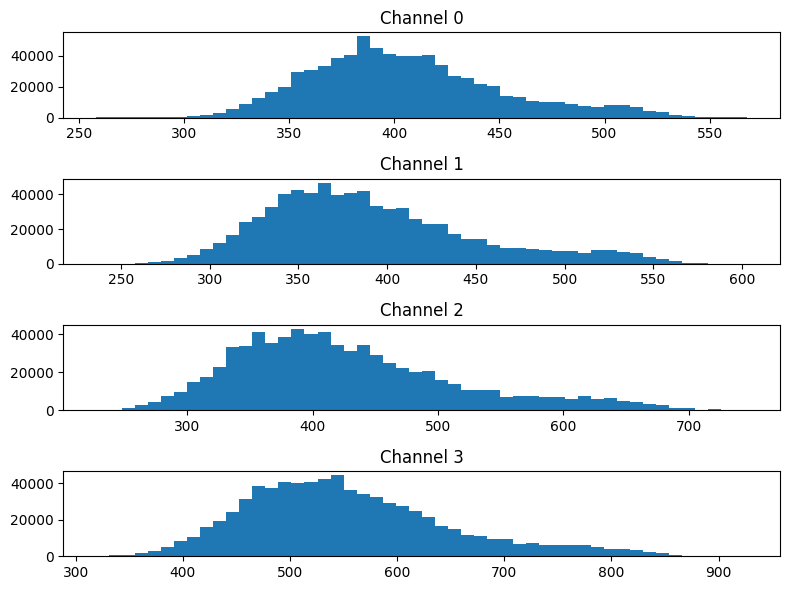

In [57]:
# Plot histograms of pixel values for each channel
num_channels = val_image_patches.shape[3]

fig, axes = plt.subplots(num_channels, 1, figsize=(8, 6))

for c in range(num_channels):
    channel_data = val_image_patches[:, :, :, c].flatten()
    axes[c].hist(channel_data, bins=50)
    axes[c].set_title('Channel {}'.format(c))
    
plt.tight_layout()
plt.show()

100%|██████████| 41763/41763 [00:04<00:00, 9101.22it/s]


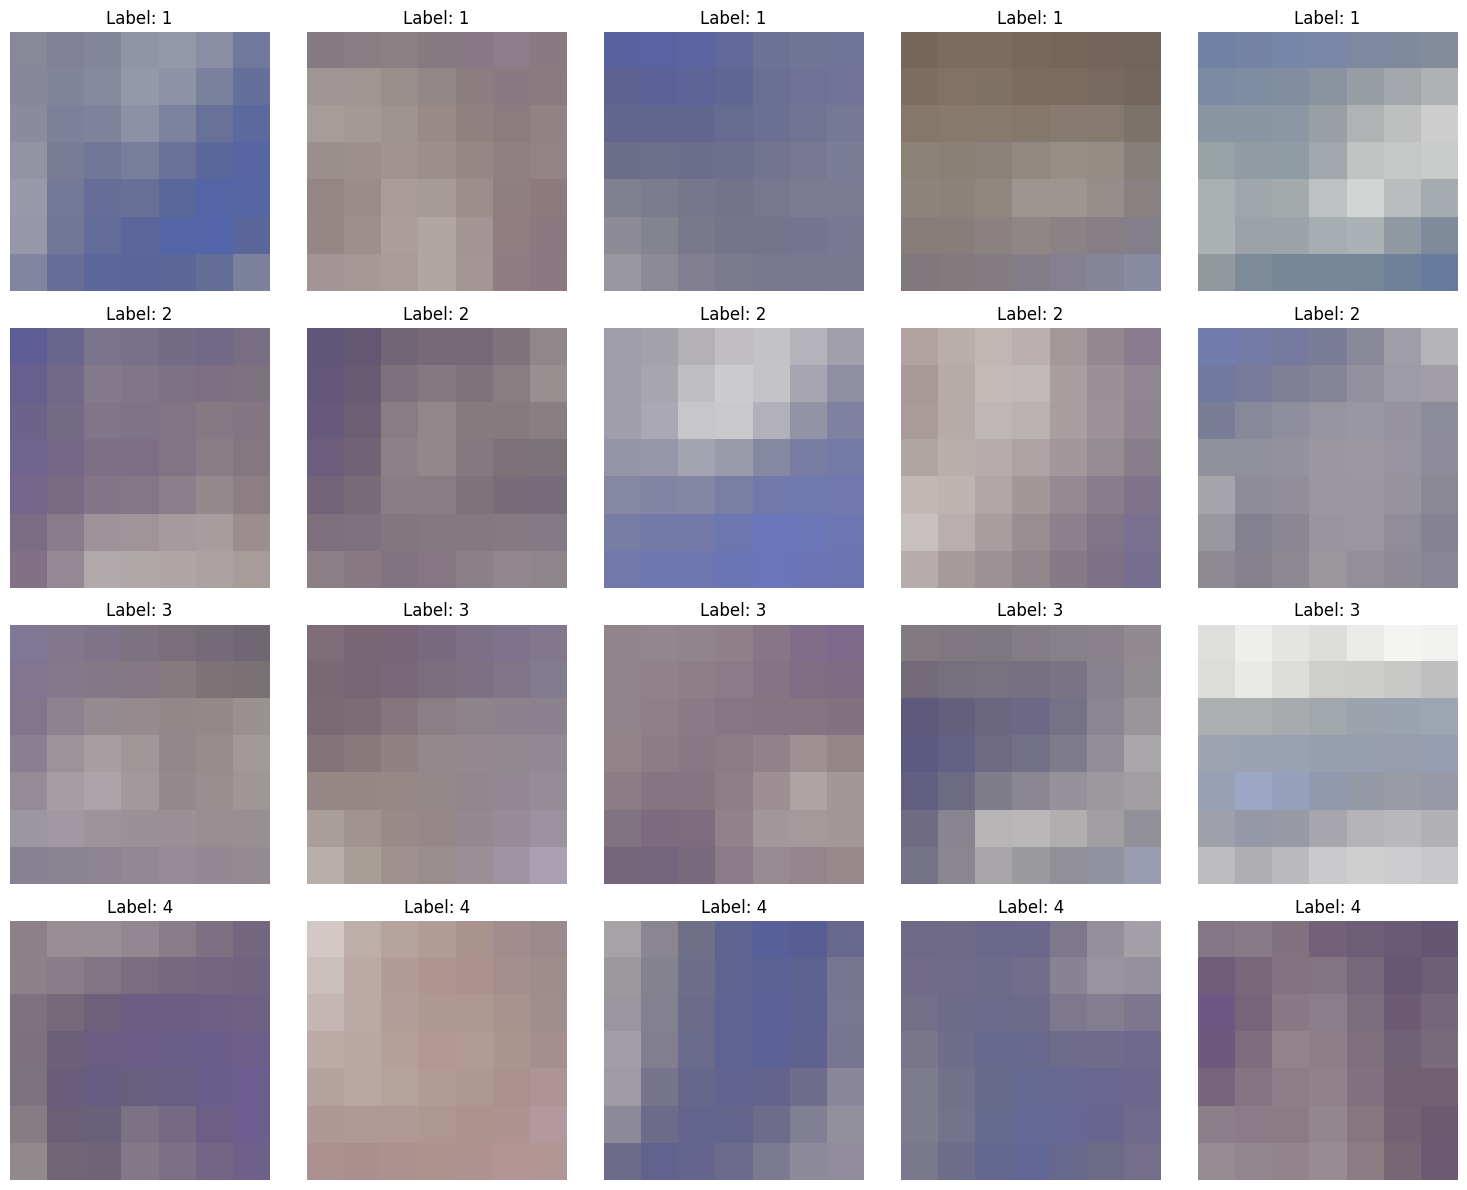

In [58]:
train_image_patches, train_patch_labels = extract_patches(image_file, patch_radius, train_path)

num_patches = train_image_patches.shape[0]
num_patches

import random

num_display = 5
labels_to_display = set(train_patch_labels)  # Get unique labels

fig, axes = plt.subplots(len(labels_to_display), num_display, figsize=(15, 3*len(labels_to_display)))

for i, label in enumerate(labels_to_display):
    patches = train_image_patches[train_patch_labels == label]
    random_indices = random.sample(range(len(patches)), num_display)
    
    for j, idx in enumerate(random_indices):
        patch = patches[idx]
        
        # Normalize the patch
        normalized_patch = (patch - patch.min()) / (patch.max() - patch.min())
        
        axes[i, j].imshow(normalized_patch)
        axes[i, j].set_title('Label: {}'.format(label))
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

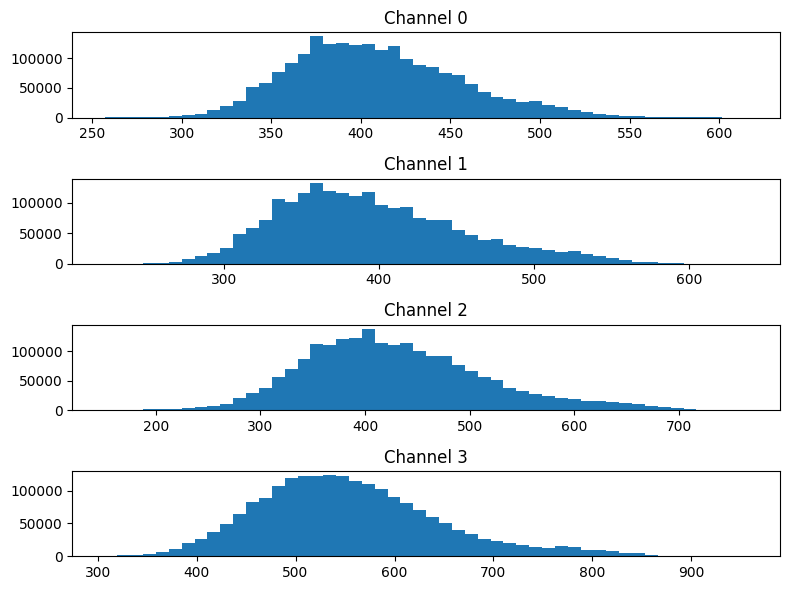

In [59]:
# Plot histograms of pixel values for each channel
num_channels = train_image_patches.shape[3]

fig, axes = plt.subplots(num_channels, 1, figsize=(8, 6))

for c in range(num_channels):
    channel_data = train_image_patches[:, :, :, c].flatten()
    axes[c].hist(channel_data, bins=50)
    axes[c].set_title('Channel {}'.format(c))
    
plt.tight_layout()
plt.show()

100%|██████████| 26105/26105 [00:02<00:00, 8922.46it/s]


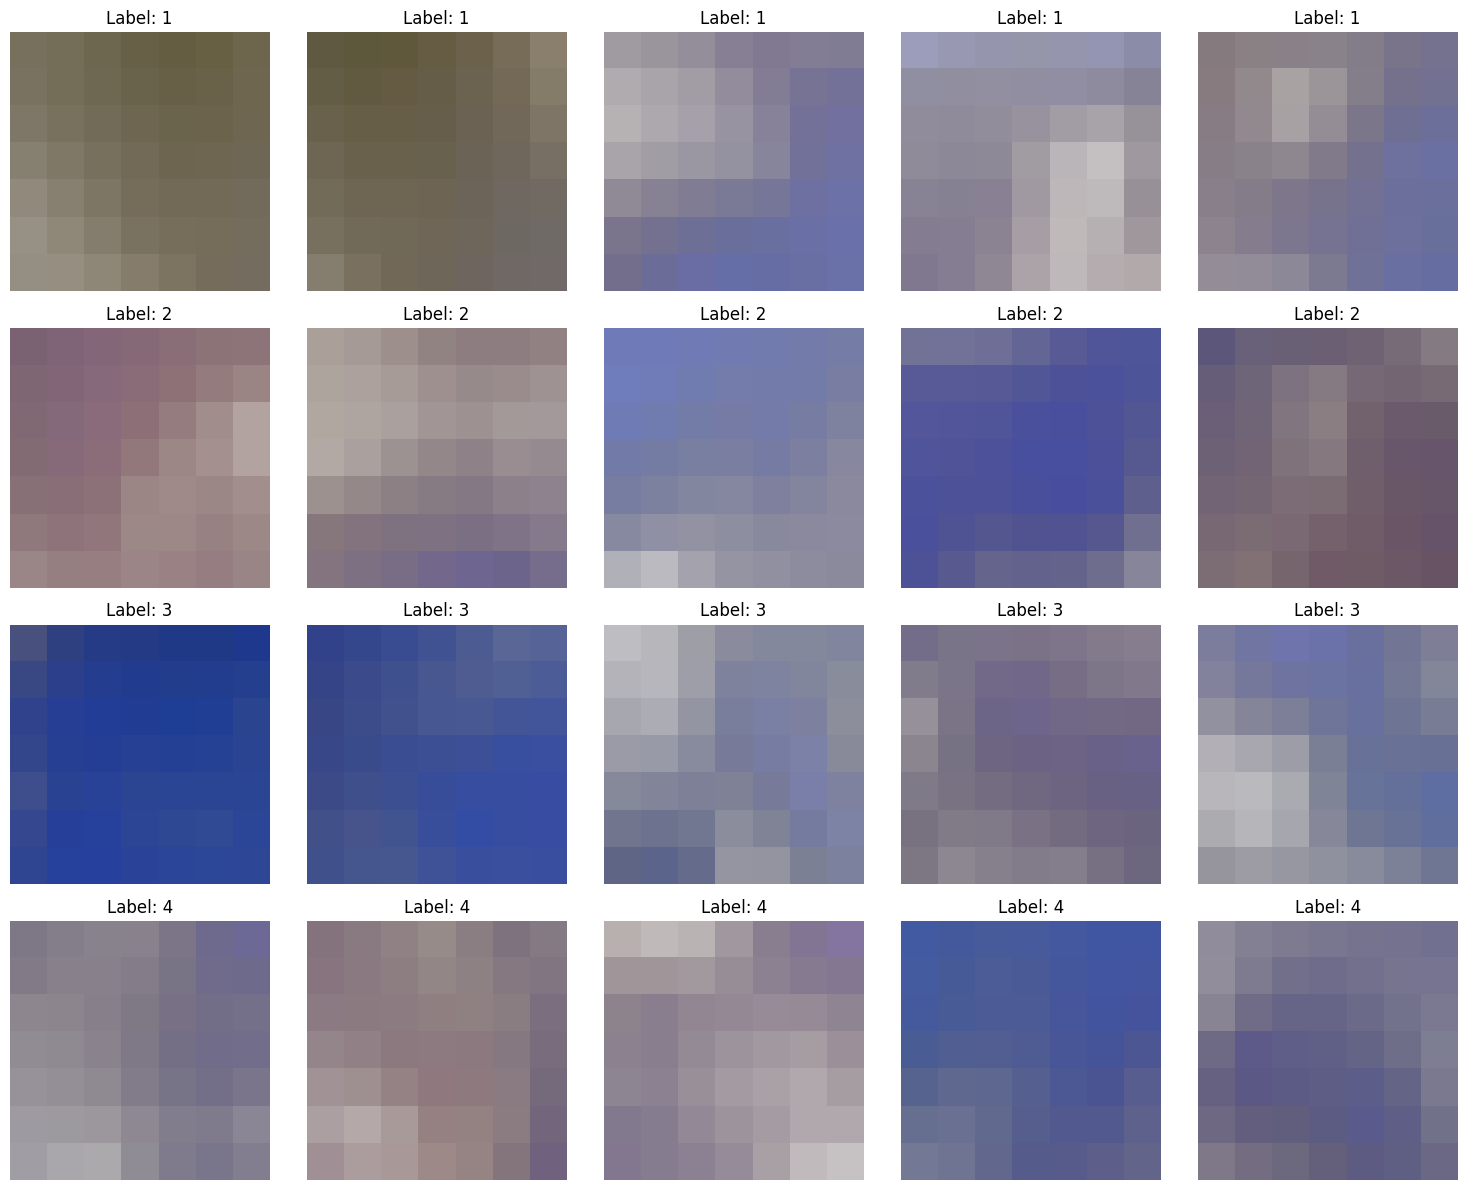

In [60]:
test_image_patches, test_patch_labels = extract_patches(image_file, patch_radius, test_path)

num_patches = test_image_patches.shape[0]
num_patches

import random

num_display = 5
labels_to_display = set(test_patch_labels)  # Get unique labels

fig, axes = plt.subplots(len(labels_to_display), num_display, figsize=(15, 3*len(labels_to_display)))

for i, label in enumerate(labels_to_display):
    patches = test_image_patches[test_patch_labels == label]
    random_indices = random.sample(range(len(patches)), num_display)
    
    for j, idx in enumerate(random_indices):
        patch = patches[idx]
        
        # Normalize the patch
        normalized_patch = (patch - patch.min()) / (patch.max() - patch.min())
        
        axes[i, j].imshow(normalized_patch)
        axes[i, j].set_title('Label: {}'.format(label))
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

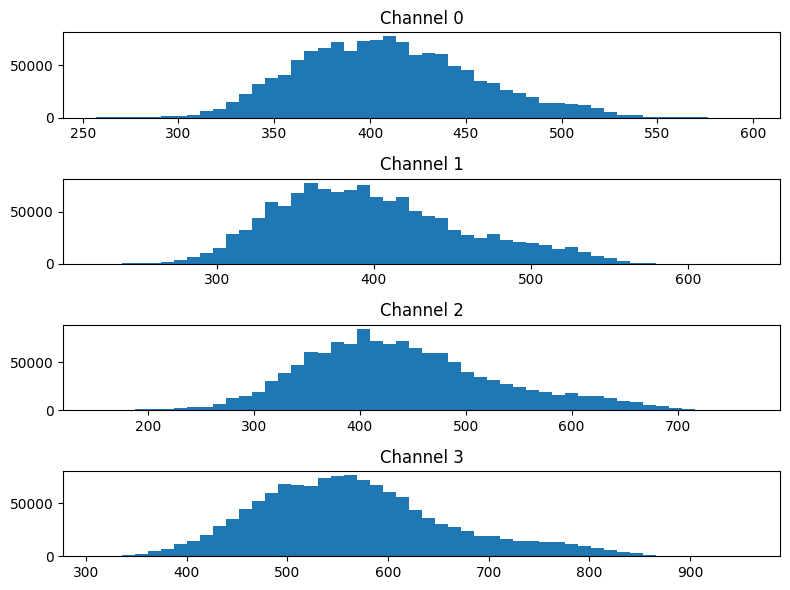

In [61]:
# Plot histograms of pixel values for each channel
num_channels = test_image_patches.shape[3]

fig, axes = plt.subplots(num_channels, 1, figsize=(8, 6))

for c in range(num_channels):
    channel_data = test_image_patches[:, :, :, c].flatten()
    axes[c].hist(channel_data, bins=50)
    axes[c].set_title('Channel {}'.format(c))
    
plt.tight_layout()
plt.show()

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Cropping2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [74]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [64]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense

input_shape = train_image_patches.shape[1:]

num_classes = 4

# Step 2: Create a Sequential model
model = Sequential()

# Define a function to create your CNN model
def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape= input_shape))
    model.add(Activation(activation))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation(activation))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for your model
model = KerasClassifier(build_fn=create_model)

# Define the parameter grid for grid search
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu', 'sigmoid']
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(train_image_patches, train_patch_labels)

# Print the best parameters and accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

<ipython-input-64-c4c8ed4ff53a>:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


1306/1306 [==============================] - 6s 3ms/step - loss: 2.4551 - accuracy: 0.4257
Best Parameters:  {'activation': 'relu', 'optimizer': 'adam'}
Best Accuracy:  0.386322816212972


In [92]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

input_shape = train_image_patches.shape[1:]

num_classes = 4

# Step 2: Create a Sequential model
model = Sequential()

# Define a function to create your CNN model
def create_model(num_layers=2, learning_rate=0.001, optimizer='adam', activation='relu', dropout_rate=0.0, epochs = 20, batch_size = 8):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape= input_shape))
    model.add(Activation(activation))

    for _ in range(num_layers-1):
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for your model
model = KerasClassifier(build_fn=create_model)

<ipython-input-92-20651e3f9924>:51: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


In [96]:
# Define the parameter grid for grid search
param_grid = {
    'num_layers': [2,3,4],
    'learning_rate': [0.0001],
    #'optimizer': ['adam', 'rmsprop', 'sgd'],
    #'activation': ['relu', 'softmax'],
    'dropout_rate': [0.0],
    'epochs': [20],
    'batch_size': [8, 16, 32]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring = 'f1_macro')
grid_result = grid.fit(train_image_patches, train_patch_labels)

results = grid_result.cv_results_
print(results['params'])

# Print the best parameters and accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

Epoch 1/20
3481/3481 [==============================] - 14s 3ms/step - loss: 3.3120 - accuracy: 0.4062
Epoch 2/20
3481/3481 [==============================] - 15s 4ms/step - loss: 1.5859 - accuracy: 0.4703
Epoch 3/20
3481/3481 [==============================] - 12s 3ms/step - loss: 1.2340 - accuracy: 0.5175
Epoch 4/20
3481/3481 [==============================] - 12s 3ms/step - loss: 1.0809 - accuracy: 0.5517
Epoch 5/20
3481/3481 [==============================] - 12s 3ms/step - loss: 0.9720 - accuracy: 0.5839
Epoch 6/20
3481/3481 [==============================] - 12s 4ms/step - loss: 0.8891 - accuracy: 0.6153
Epoch 7/20
3481/3481 [==============================] - 12s 3ms/step - loss: 0.8309 - accuracy: 0.6409
Epoch 8/20
3481/3481 [==============================] - 12s 3ms/step - loss: 0.7719 - accuracy: 0.6694
Epoch 9/20
3481/3481 [==============================] - 11s 3ms/step - loss: 0.7293 - accuracy: 0.6895
Epoch 10/20
3481/3481 [==============================] - 11s 3ms/step - l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipy

5221/5221 [==============================] - 19s 3ms/step - loss: 2.7521 - accuracy: 0.3999
Epoch 2/20
5221/5221 [==============================] - 17s 3ms/step - loss: 1.3608 - accuracy: 0.4553
Epoch 3/20
5221/5221 [==============================] - 17s 3ms/step - loss: 1.1475 - accuracy: 0.5017
Epoch 4/20
5221/5221 [==============================] - 17s 3ms/step - loss: 1.0625 - accuracy: 0.5356
Epoch 5/20
5221/5221 [==============================] - 17s 3ms/step - loss: 0.9993 - accuracy: 0.5629
Epoch 6/20
5221/5221 [==============================] - 17s 3ms/step - loss: 0.9391 - accuracy: 0.5908
Epoch 7/20
5221/5221 [==============================] - 17s 3ms/step - loss: 0.8814 - accuracy: 0.6234
Epoch 8/20
5221/5221 [==============================] - 17s 3ms/step - loss: 0.8279 - accuracy: 0.6496
Epoch 9/20
5221/5221 [==============================] - 17s 3ms/step - loss: 0.7821 - accuracy: 0.6702
Epoch 10/20
5221/5221 [==============================] - 17s 3ms/step - loss: 0.7463

In [105]:
best_params = {
    'num_layers': grid_result.best_params_['num_layers'],
    'learning_rate': grid_result.best_params_['learning_rate'],
    #'optimizer': grid_result.best_params_['optimizer'],
    'dropout_rate': grid_result.best_params_['dropout_rate'],
    'epochs': grid_result.best_params_['epochs'],
    'batch_size': grid_result.best_params_['batch_size']
}
print(best_params)

{'num_layers': 2, 'learning_rate': 0.0001, 'dropout_rate': 0.0, 'epochs': 20, 'batch_size': 8}


In [107]:
# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

input_shape = train_image_patches.shape[1:]

num_classes = 4

# Step 2: Create a Sequential model
model = Sequential()

# Define a function to create your CNN model
def create_model(num_layers=2, learning_rate=0.0001, optimizer='adam', activation='relu', dropout_rate=0.0, epochs = 20, batch_size = 8):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape= input_shape))
    model.add(Activation(activation))

    for _ in range(num_layers-1):
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation(activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for your model
model = KerasClassifier(build_fn=create_model)
history = model.fit(train_image_patches, train_patch_labels, epochs=20, batch_size=8, validation_data=(val_image_patches, val_patch_labels))

Epoch 1/20


<ipython-input-107-772e35cc94cc>:43: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


5221/5221 [==============================] - 23s 4ms/step - loss: 2.5987 - accuracy: 0.4063 - val_loss: nan - val_accuracy: 0.1077
Epoch 2/20
5221/5221 [==============================] - 20s 4ms/step - loss: 1.3576 - accuracy: 0.4605 - val_loss: nan - val_accuracy: 0.1291
Epoch 3/20
5221/5221 [==============================] - 20s 4ms/step - loss: 1.1594 - accuracy: 0.5003 - val_loss: nan - val_accuracy: 0.1332
Epoch 4/20
5221/5221 [==============================] - 21s 4ms/step - loss: 1.0760 - accuracy: 0.5320 - val_loss: nan - val_accuracy: 0.1026
Epoch 5/20
5221/5221 [==============================] - 22s 4ms/step - loss: 1.0174 - accuracy: 0.5564 - val_loss: nan - val_accuracy: 0.1914
Epoch 6/20
5221/5221 [==============================] - 21s 4ms/step - loss: 0.9571 - accuracy: 0.5859 - val_loss: nan - val_accuracy: 0.1451
Epoch 7/20
5221/5221 [==============================] - 21s 4ms/step - loss: 0.9013 - accuracy: 0.6145 - val_loss: nan - val_accuracy: 0.1651
Epoch 8/20
5221/5

In [108]:
model_name = "cnn"
import os
import joblib

out_path = '/content/drive/MyDrive/MIT808 Data'

model_path = os.path.join(out_path, f"{model_name}.joblib")

joblib.dump(model, model_path)

print(f"CNN model saved at {model_path}")

CNN model saved at /content/drive/MyDrive/MIT808 Data/cnn.joblib


In [118]:
# Calculate the test accuracy
test_accuracy = model.score(test_image_patches, test_patch_labels)

print('Test Accuracy:', test_accuracy)

816/816 [==============================] - 2s 2ms/step - loss: 1.9289 - accuracy: 0.6531
Test Accuracy: 0.6531316041946411


In [120]:
from sklearn.metrics import f1_score
# Get predicted labels
y_pred = model.predict(test_image_patches)

f1 = f1_score(test_patch_labels, y_pred, average='macro')

print('F1 Score:', f1)

816/816 [==============================] - 2s 2ms/step
F1 Score: 0.5790436548706345
